<h1>Forecasting Test 2<h1>

1. Converting dataframe dates to weeks only.
2. Will be testing LSTM vs ARIMA model performance using RMSE.
3. Predict 24 weeks using the best model.
4. Comparing with actual data to check accuracy of predict.

In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from tensorflow.keras.layers import LSTM, Dense
from sklearn.metrics import mean_squared_error
from tensorflow.keras.models import Sequential
from IPython.core.interactiveshell import InteractiveShell
from sklearn.model_selection import KFold
InteractiveShell.ast_node_interactivity = "all"
%matplotlib inline
sns.set()
pd.options.display.max_rows = 100

df = pd.read_csv('.\Datasets\CR_COST_FC_new.csv', converters={'PARTY_ID': str, 'COM_ID': str, 'CNTR_SIZE': str})
df['POD'] = pd.to_datetime(df['POD'])
df['ENCODED_TYPE'] = df['ENCODED_TYPE'].fillna(-1).astype(int)
df = df.dropna(subset=['ENCODED_TYPE'])
df['RATE'] = df['RATE'].fillna(-1).astype(int)
df = df.dropna(subset=['RATE'])
df['ENCODED_TYPE'] = df['ENCODED_TYPE'].astype(int)

# Remove NAN values
df_clean= df.dropna().reset_index(drop=True)

df_clean.head()
df_clean.info()
print(f'Dataset size: {df_clean.shape}')

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 54722 entries, 0 to 54721
Data columns (total 17 columns):
 #   Column        Non-Null Count  Dtype         
---  ------        --------------  -----         
 0   COM_ID        54722 non-null  object        
 1   PARTY_ID      54722 non-null  object        
 2   PARTY_ID_EN   54722 non-null  int64         
 3   PARTY_NAME    54722 non-null  object        
 4   CSL_ID        54722 non-null  object        
 5   ETA_ETD_NO    54722 non-null  int64         
 6   ETD_POL_D     54722 non-null  object        
 7   POD_ID        54722 non-null  object        
 8   POD           54722 non-null  datetime64[ns]
 9   CNTR_ID       54722 non-null  object        
 10  CNTR_SIZE     54722 non-null  object        
 11  CNTR_TYPE     54722 non-null  object        
 12  COST_TERM     54722 non-null  object        
 13  RATE          54722 non-null  int32         
 14  ENCODED_TYPE  54722 non-null  int32         
 15  ENCODED_TERM  54722 non-null  int64 

In [2]:
sel_col = ['CSL_ID', 'CNTR_ID','POD_ID','ETD_POL_D','PARTY_ID',
           'PARTY_NAME','POD','CNTR_SIZE','CNTR_TYPE','RATE']

df_fc = df_clean[sel_col]
df_fc.head()
df_fc.info()

,CSL_ID,CNTR_ID,POD_ID,ETD_POL_D,PARTY_ID,PARTY_NAME,POD,CNTR_SIZE,CNTR_TYPE,RATE
0,ECS010060100191,CTNR010060201232,HELSINKI,FIHEL,010003678,OY TAVATUR SHIPPING LTD,2006-02-28,20,GP,675
1,ECS010060100465,CTNR010060300014,BUSAN,KRPUS,010004286,"GLOBELINK KOREA CO., LTD",2006-03-03,40,HC,390
2,ECS010060100321,CTNR010060201198,AUCKLAND,NZAKL,01005136,MONDIALE FREIGHT SERVICES LIMITED-AUCKLAND,2006-02-27,40,HC NOR,1615
3,ECS010060200201,CTNR010060300119,ADELAIDE,AUADL,01002775,GLOBELINK INTERNATIONAL PTY LTD-ADELAIDE,2006-03-06,40,HC,700
4,ECS010060200146,CTNR010060300185,MARSEILLE,FRMRS,01001088,CARGO LINES S.A.-LE HAVRE,2006-03-07,20,GP,675


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 54722 entries, 0 to 54721
Data columns (total 10 columns):
 #   Column      Non-Null Count  Dtype         
---  ------      --------------  -----         
 0   CSL_ID      54722 non-null  object        
 1   CNTR_ID     54722 non-null  object        
 2   POD_ID      54722 non-null  object        
 3   ETD_POL_D   54722 non-null  object        
 4   PARTY_ID    54722 non-null  object        
 5   PARTY_NAME  54722 non-null  object        
 6   POD         54722 non-null  datetime64[ns]
 7   CNTR_SIZE   54722 non-null  object        
 8   CNTR_TYPE   54722 non-null  object        
 9   RATE        54722 non-null  int32         
dtypes: datetime64[ns](1), int32(1), object(8)
memory usage: 4.0+ MB


In [3]:
# filter out rows where the year is 2002
df_filtered = df_fc[df_fc['POD'].dt.year != 2002]
df_filtered.head()
df_filtered.info()

# Checking if year 2002 is removed
df_filtered['POD'].dt.year.unique()

,CSL_ID,CNTR_ID,POD_ID,ETD_POL_D,PARTY_ID,PARTY_NAME,POD,CNTR_SIZE,CNTR_TYPE,RATE
0,ECS010060100191,CTNR010060201232,HELSINKI,FIHEL,010003678,OY TAVATUR SHIPPING LTD,2006-02-28,20,GP,675
1,ECS010060100465,CTNR010060300014,BUSAN,KRPUS,010004286,"GLOBELINK KOREA CO., LTD",2006-03-03,40,HC,390
2,ECS010060100321,CTNR010060201198,AUCKLAND,NZAKL,01005136,MONDIALE FREIGHT SERVICES LIMITED-AUCKLAND,2006-02-27,40,HC NOR,1615
3,ECS010060200201,CTNR010060300119,ADELAIDE,AUADL,01002775,GLOBELINK INTERNATIONAL PTY LTD-ADELAIDE,2006-03-06,40,HC,700
4,ECS010060200146,CTNR010060300185,MARSEILLE,FRMRS,01001088,CARGO LINES S.A.-LE HAVRE,2006-03-07,20,GP,675


<class 'pandas.core.frame.DataFrame'>
Int64Index: 54721 entries, 0 to 54721
Data columns (total 10 columns):
 #   Column      Non-Null Count  Dtype         
---  ------      --------------  -----         
 0   CSL_ID      54721 non-null  object        
 1   CNTR_ID     54721 non-null  object        
 2   POD_ID      54721 non-null  object        
 3   ETD_POL_D   54721 non-null  object        
 4   PARTY_ID    54721 non-null  object        
 5   PARTY_NAME  54721 non-null  object        
 6   POD         54721 non-null  datetime64[ns]
 7   CNTR_SIZE   54721 non-null  object        
 8   CNTR_TYPE   54721 non-null  object        
 9   RATE        54721 non-null  int32         
dtypes: datetime64[ns](1), int32(1), object(8)
memory usage: 4.4+ MB


array([2006, 2005, 2007, 2008, 2009, 2010, 2011, 2012, 2013, 2014, 2015,
       2018, 2019, 2020, 2021, 2016, 2017, 2022, 2023], dtype=int64)

In [4]:
# Sorting the dates 
df_filtered = df_filtered.sort_values(by='POD').reset_index(drop=True)
df_filtered.head()
df_filtered.tail()
df_filtered['POD'].dt.year.unique()

,CSL_ID,CNTR_ID,POD_ID,ETD_POL_D,PARTY_ID,PARTY_NAME,POD,CNTR_SIZE,CNTR_TYPE,RATE
0,ECS01050600224,CTNR010050700354,ROTTERDAM,NLRTM,01008827,YANG MING (SINGAPORE) PTE. LTD.,2005-07-15,40,HC NOR,1620
1,ECS01050600610,CTNR010050700353,FELIXSTOWE,GBFXT,01002303,GLOBELINK FALLOW LIMITED,2005-07-15,40,GP,1800
2,ECS01050600041,CTNR010050700351,AUCKLAND,NZAKL,01005136,MONDIALE FREIGHT SERVICES LIMITED-AUCKLAND,2005-07-15,40,HC NOR,2170
3,ECS01050600163,CTNR010050700370,PASIR GUDANG,MYPGU,01002767,GLOBELINK CONTAINER LINES (JB) S/B,2005-07-15,40,HC,280
4,ECS01050600456,CTNR010050700450,KARACHI (KICT),PKKHI,01002783,GLOBELINK PAKISTAN (PVT) LTD,2005-07-16,40,HC,1625


,CSL_ID,CNTR_ID,POD_ID,ETD_POL_D,PARTY_ID,PARTY_NAME,POD,CNTR_SIZE,CNTR_TYPE,RATE
54716,ECS010230400526,010000573399,VALPARAISO,CLVAP,010006350,CRAFT MULTIMODAL CHILE SPA,2023-05-24,40,HC,1300
54717,ECS010230400525,010000582631,CALLAO,PECLL,010026711,CRAFT MULTIMODAL PERU S.A,2023-05-24,40,HC NOR,1300
54718,ECS010230400452,010000580585,BUENOS AIRES,ARBUE,010006300,CRAFT ARGENTINA SA,2023-05-25,40,HC,2300
54719,ECS010230400451,010000554136,MONTEVIDEO,UYMVD,010021385,CRAFT URUGUAY CHEBURIN S.A,2023-05-25,40,HC,1100
54720,ECS010230400352,010000588769,ASHDOD,ILASH,010008035,MAYAN OVERSEAS LTD,2023-05-27,20,GP,2100


array([2005, 2006, 2007, 2008, 2009, 2010, 2011, 2012, 2013, 2014, 2015,
       2016, 2017, 2018, 2019, 2020, 2021, 2022, 2023], dtype=int64)

In [5]:
def filter_dataframe(df):
    filtered_dataframes = {}

    for (port, size, ctype, party_id), group in df.groupby(['POD_ID', 'CNTR_SIZE', 'CNTR_TYPE', 'PARTY_ID']):
        group = group.reset_index(drop=True).sort_values(by='POD')
        df_id = f"Port_{port}_Size_{size}_Type_{ctype}_PartyID_{party_id}"
        filtered_dataframes[df_id] = group

    return filtered_dataframes

In [6]:
filtered_dataframes = filter_dataframe(df_filtered)

# Show case some samples of keys
df_ids = list(filtered_dataframes.keys())
print(list(df_ids))
print(len(list(df_ids)))

['Port_(CONSTANZA)_Size_40_Type_GP_PartyID_010007816', 'Port_(CONSTANZA)_Size_40_Type_HC_PartyID_010007816', 'Port_AARHUS_Size_20_Type_GP_PartyID_01000043', 'Port_AARHUS_Size_20_Type_GP_PartyID_0100027830', 'Port_AARHUS_Size_20_Type_GP_PartyID_0100028193', 'Port_AARHUS_Size_20_Type_GP_PartyID_010006666', 'Port_AARHUS_Size_40_Type_GP_PartyID_01000043', 'Port_AARHUS_Size_40_Type_HC_PartyID_01000043', 'Port_AARHUS_Size_40_Type_HC_PartyID_0100027830', 'Port_AARHUS_Size_40_Type_HC_PartyID_0100028193', 'Port_AARHUS_Size_40_Type_HC_PartyID_010006666', 'Port_ABIDJAN_Size_20_Type_GP_PartyID_0100027878', 'Port_ABIDJAN_Size_40_Type_HC_PartyID_010021097', 'Port_ADELAIDE_Size_20_Type_GP_PartyID_01002775', 'Port_ADELAIDE_Size_40_Type_GP_PartyID_01002775', 'Port_ADELAIDE_Size_40_Type_HC_PartyID_01002775', 'Port_ADELAIDE_Size_40_Type_HC_PartyID_01005078', 'Port_ADELAIDE_Size_40_Type_HC NOR_PartyID_01002775', 'Port_ADELAIDE(AU)_Size_20_Type_GP_PartyID_01002775', 'Port_ADELAIDE(AU)_Size_40_Type_HC_Party

<h4>Getting the top 5 ports</h4>

In [7]:
# Get a dictionary with key and number of rows for each dataframe in filtered_dataframes
key_row_counts = {key: len(filtered_dataframes[key]) for key in filtered_dataframes}

# Sort the key_row_counts dictionary by value (number of rows) in descending order
sorted_key_row_counts = sorted(key_row_counts.items(), key=lambda item: item[1], reverse=True)
# print(sorted_key_row_counts)

# Get the top 10 keys with the most rows
top_10_keys_tuple = sorted_key_row_counts[:10]


# Create a dictionary with the top 5 keys and their corresponding dataframes (with up to 5 rows per dataframe)
filtered_dataframes_subset = {}

for key, row_count in top_10_keys_tuple:
    filtered_dataframes_subset[key] = filtered_dataframes[key][:10]
    print(f"Number of rows in {key}: {row_count}")

# print(filtered_dataframes_subset.keys())

Number of rows in Port_BUSAN_Size_40_Type_HC_PartyID_010004286: 1712
Number of rows in Port_AUCKLAND_Size_40_Type_HC_PartyID_01005136: 1704
Number of rows in Port_MELBOURNE_Size_40_Type_HC_PartyID_01002778: 1341
Number of rows in Port_SYDNEY_Size_40_Type_HC_PartyID_01002779: 1308
Number of rows in Port_DUBAI (JEBEL ALI)_Size_40_Type_HC_PartyID_01002788: 1070
Number of rows in Port_HOCHIMINH CAT LAI,VIETNAM_Size_40_Type_HC_PartyID_010005256: 941
Number of rows in Port_AUCKLAND_Size_40_Type_HC NOR_PartyID_01005136: 869
Number of rows in Port_FREMANTLE_Size_40_Type_HC_PartyID_01002777: 826
Number of rows in Port_BRISBANE_Size_40_Type_HC_PartyID_01002776: 807
Number of rows in Port_MANILA (NORTH HARBOUR)_Size_40_Type_HC_PartyID_010021727: 692


<h4>Selecting a dataframe for testing</h4>

In [8]:
# Selected dataframe
sel_df = filtered_dataframes['Port_BUSAN_Size_40_Type_HC_PartyID_010004286']
sel_df.head()
sel_df.info()

,CSL_ID,CNTR_ID,POD_ID,ETD_POL_D,PARTY_ID,PARTY_NAME,POD,CNTR_SIZE,CNTR_TYPE,RATE
0,ECS010050800407,CTNR010050901151,BUSAN,KRPUS,010004286,"GLOBELINK KOREA CO., LTD",2005-10-03,40,HC,390
1,ECS010050800407,CTNR010050901379,BUSAN,KRPUS,010004286,"GLOBELINK KOREA CO., LTD",2005-10-03,40,HC,390
2,ECS010050900468,CTNR010051000081,BUSAN,KRPUS,010004286,"GLOBELINK KOREA CO., LTD",2005-10-07,40,HC,390
3,ECS010050900468,CTNR010050901461,BUSAN,KRPUS,010004286,"GLOBELINK KOREA CO., LTD",2005-10-07,40,HC,390
4,ECS010050900469,CTNR010051000434,BUSAN,KRPUS,010004286,"GLOBELINK KOREA CO., LTD",2005-10-14,40,HC,390


<class 'pandas.core.frame.DataFrame'>
Int64Index: 1712 entries, 0 to 1711
Data columns (total 10 columns):
 #   Column      Non-Null Count  Dtype         
---  ------      --------------  -----         
 0   CSL_ID      1712 non-null   object        
 1   CNTR_ID     1712 non-null   object        
 2   POD_ID      1712 non-null   object        
 3   ETD_POL_D   1712 non-null   object        
 4   PARTY_ID    1712 non-null   object        
 5   PARTY_NAME  1712 non-null   object        
 6   POD         1712 non-null   datetime64[ns]
 7   CNTR_SIZE   1712 non-null   object        
 8   CNTR_TYPE   1712 non-null   object        
 9   RATE        1712 non-null   int32         
dtypes: datetime64[ns](1), int32(1), object(8)
memory usage: 140.4+ KB


In [9]:
# Check for duplicates and keep only one instance of each unique combination
sel_df = sel_df.drop_duplicates(subset=['POD', 'RATE']).reset_index(drop=True)
sel_df.info()
sel_df.head(15)


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1139 entries, 0 to 1138
Data columns (total 10 columns):
 #   Column      Non-Null Count  Dtype         
---  ------      --------------  -----         
 0   CSL_ID      1139 non-null   object        
 1   CNTR_ID     1139 non-null   object        
 2   POD_ID      1139 non-null   object        
 3   ETD_POL_D   1139 non-null   object        
 4   PARTY_ID    1139 non-null   object        
 5   PARTY_NAME  1139 non-null   object        
 6   POD         1139 non-null   datetime64[ns]
 7   CNTR_SIZE   1139 non-null   object        
 8   CNTR_TYPE   1139 non-null   object        
 9   RATE        1139 non-null   int32         
dtypes: datetime64[ns](1), int32(1), object(8)
memory usage: 84.7+ KB


,CSL_ID,CNTR_ID,POD_ID,ETD_POL_D,PARTY_ID,PARTY_NAME,POD,CNTR_SIZE,CNTR_TYPE,RATE
0,ECS010050800407,CTNR010050901151,BUSAN,KRPUS,010004286,"GLOBELINK KOREA CO., LTD",2005-10-03,40,HC,390
1,ECS010050900468,CTNR010051000081,BUSAN,KRPUS,010004286,"GLOBELINK KOREA CO., LTD",2005-10-07,40,HC,390
2,ECS010050900469,CTNR010051000434,BUSAN,KRPUS,010004286,"GLOBELINK KOREA CO., LTD",2005-10-14,40,HC,390
3,ECS010050900471,CTNR010051001330,BUSAN,KRPUS,010004286,"GLOBELINK KOREA CO., LTD",2005-10-30,40,HC,390
4,ECS010051000380,CTNR010051001332,BUSAN,KRPUS,010004286,"GLOBELINK KOREA CO., LTD",2005-11-03,40,HC,390
5,ECS010051000381,CTNR010051100185,BUSAN,KRPUS,010004286,"GLOBELINK KOREA CO., LTD",2005-11-12,40,HC,390
6,ECS010051000382,CTNR010051101339,BUSAN,KRPUS,010004286,"GLOBELINK KOREA CO., LTD",2005-11-28,40,HC,390
7,ECS010051100223,CTNR010051101279,BUSAN,KRPUS,010004286,"GLOBELINK KOREA CO., LTD",2005-12-04,40,HC,390
8,ECS010051100224,CTNR010051200319,BUSAN,KRPUS,010004286,"GLOBELINK KOREA CO., LTD",2005-12-10,40,HC,390
9,ECS010051100227,CTNR010051201287,BUSAN,KRPUS,010004286,"GLOBELINK KOREA CO., LTD",2005-12-31,40,HC,390


In [10]:
# Initialize the reference date with the first date in the "POD" column
reference_date = sel_df['POD'].iloc[0]

# Calculate the difference in days and print it out
for index, date in enumerate(sel_df['POD']):
    if index > 0:
        prev_date = sel_df['POD'].iloc[index - 1]
        days_difference = (date - prev_date).days
        print(f"Difference between {prev_date}and {date}: {days_difference} days")

Difference between 2005-10-03 00:00:00and 2005-10-07 00:00:00: 4 days
Difference between 2005-10-07 00:00:00and 2005-10-14 00:00:00: 7 days
Difference between 2005-10-14 00:00:00and 2005-10-30 00:00:00: 16 days
Difference between 2005-10-30 00:00:00and 2005-11-03 00:00:00: 4 days
Difference between 2005-11-03 00:00:00and 2005-11-12 00:00:00: 9 days
Difference between 2005-11-12 00:00:00and 2005-11-28 00:00:00: 16 days
Difference between 2005-11-28 00:00:00and 2005-12-04 00:00:00: 6 days
Difference between 2005-12-04 00:00:00and 2005-12-10 00:00:00: 6 days
Difference between 2005-12-10 00:00:00and 2005-12-31 00:00:00: 21 days
Difference between 2005-12-31 00:00:00and 2006-01-07 00:00:00: 7 days
Difference between 2006-01-07 00:00:00and 2006-02-04 00:00:00: 28 days
Difference between 2006-02-04 00:00:00and 2006-02-10 00:00:00: 6 days
Difference between 2006-02-10 00:00:00and 2006-02-17 00:00:00: 7 days
Difference between 2006-02-17 00:00:00and 2006-02-24 00:00:00: 7 days
Difference betwe

<h4>Filling unknown values and formating by week</h4>
1. If data before is in the same month then backward fill.<br>
2. If data before is not the same month then forward fill.

In [11]:
# Create Year, Month, and Week columns in the original dataframe
sel_df['Year'] = sel_df['POD'].dt.year
sel_df['Month'] = sel_df['POD'].dt.month
sel_df['Week'] = sel_df['POD'].dt.isocalendar().week

# Create a new dataframe with every week in the range
all_weeks = pd.date_range(start=sel_df['POD'].min(), end=sel_df['POD'].max(), freq='W')
all_weeks_df = pd.DataFrame(all_weeks, columns=['POD'])
all_weeks_df['Year'] = all_weeks_df['POD'].dt.year
all_weeks_df['Month'] = all_weeks_df['POD'].dt.month
all_weeks_df['Week'] = all_weeks_df['POD'].dt.isocalendar().week

# Merge this with your original dataframe
merged_df = pd.merge(all_weeks_df, sel_df, on=['Year', 'Month', 'Week'], how='left')

# Now you can group by year, month, and week and compute your rate
grouped = merged_df.groupby(['Year', 'Month', 'Week'])

agg_df = pd.DataFrame(columns=['Year', 'Month', 'Week', 'Rate'])

for group_name, group_df in grouped:
    year, month, week = group_name

    # Skip if no data for this week
    if group_df['RATE'].isnull().all():
        continue

    # Calculate sum and skewness of RATE values
    rate_sum = group_df['RATE'].sum()
    rate_skew = group_df['RATE'].skew()

    # Calculate mean or median based on skewness
    if rate_skew < 0:
        rate_metric = group_df['RATE'].mean()
    else:
        rate_metric = group_df['RATE'].median()

    first_day_of_year = pd.Timestamp(year=year, month=1, day=1)
    days_since_monday = (first_day_of_year.weekday() - 1) % 7
    first_monday = first_day_of_year - pd.Timedelta(days=days_since_monday)
    first_day_of_week = first_monday + pd.Timedelta(weeks=(week-1), days=0)

    new_row = {
        'YearMonthWeek': first_day_of_week,
        'Year': year,
        'Month': month,
        'Week' : week,
        'Rate': rate_metric
    }

    # Append row to aggregated dataframe
    agg_df = agg_df.append(new_row, ignore_index=True)

agg_df['YearMonthWeek_en'] = agg_df["YearMonthWeek"].dt.strftime('%Y%m%d').astype(int)
agg_df = agg_df.sort_values(by='YearMonthWeek').reset_index(drop=True)

agg_df.head(10)
agg_df.info()


C:\Users\Aloysius Wong\AppData\Local\Temp\ipykernel_2760\1712778719.py:52: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  agg_df = agg_df.append(new_row, ignore_index=True)
C:\Users\Aloysius Wong\AppData\Local\Temp\ipykernel_2760\1712778719.py:52: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  agg_df = agg_df.append(new_row, ignore_index=True)
C:\Users\Aloysius Wong\AppData\Local\Temp\ipykernel_2760\1712778719.py:52: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  agg_df = agg_df.append(new_row, ignore_index=True)
C:\Users\Aloysius Wong\AppData\Local\Temp\ipykernel_2760\1712778719.py:52: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  agg_df 

,Year,Month,Week,Rate,YearMonthWeek,YearMonthWeek_en
0,2005,10,40,390.0,2005-09-27,20050927
1,2005,10,41,390.0,2005-10-04,20051004
2,2005,10,43,390.0,2005-10-18,20051018
3,2005,11,44,390.0,2005-10-25,20051025
4,2005,11,45,390.0,2005-11-01,20051101
5,2005,12,48,390.0,2005-11-22,20051122
6,2005,12,49,390.0,2005-11-29,20051129
7,2006,1,1,390.0,2005-12-27,20051227
8,2006,2,5,390.0,2006-01-24,20060124
9,2006,2,6,390.0,2006-01-31,20060131


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 652 entries, 0 to 651
Data columns (total 6 columns):
 #   Column            Non-Null Count  Dtype         
---  ------            --------------  -----         
 0   Year              652 non-null    object        
 1   Month             652 non-null    object        
 2   Week              652 non-null    object        
 3   Rate              652 non-null    float64       
 4   YearMonthWeek     652 non-null    datetime64[ns]
 5   YearMonthWeek_en  652 non-null    int32         
dtypes: datetime64[ns](1), float64(1), int32(1), object(3)
memory usage: 28.1+ KB


<h4>Plotting with new and old data to see how much different</h4>

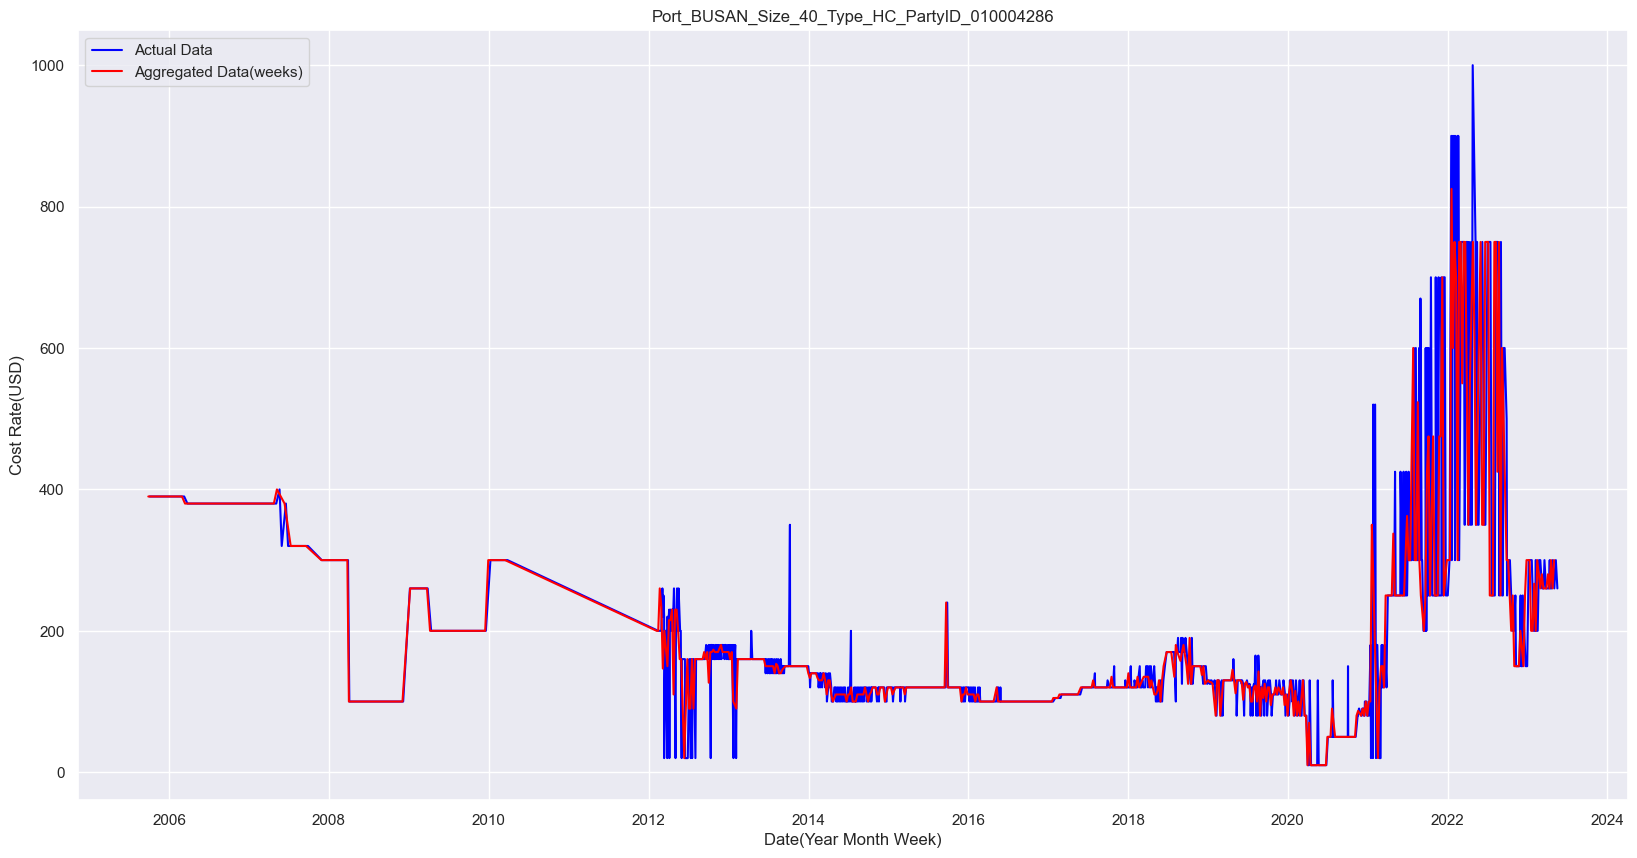

In [12]:
plt.figure(figsize=(20, 10))
plt.plot(sel_df['POD'], sel_df['RATE'], color='blue', label="Actual Data")
plt.plot(agg_df['YearMonthWeek'], agg_df['Rate'], color='red', label="Aggregated Data(weeks)")

plt.xlabel('Date(Year Month Week)')
plt.ylabel('Cost Rate(USD)')
plt.title('Port_BUSAN_Size_40_Type_HC_PartyID_010004286')
plt.legend()
plt.show();

<h4>Mean Square Error Evaluation Function</h4>

In [13]:
# Mean Square Error Function:
def calculate_RMSE(y_true, y_pred):
    return np.sqrt(mean_squared_error(y_true, y_pred))

<h4>Plot Prediction Function to see model fitting</h4>

In [14]:
def plot_predictions_v1(df, trainPredict, testPredict, look_back):
    
    # shift train predictions for plotting
    trainPredictPlot = np.empty_like(df)
    trainPredictPlot[:, :] = np.nan
    trainPredictPlot[look_back:len(trainPredict)+look_back, :] = trainPredict

    # shift test predictions for plotting
    testPredictPlot = np.empty_like(df)
    testPredictPlot[:, :] = np.nan
    print(f'testPredict shape: {testPredict.shape}')
    print(f'testPredictPlot section shape: {testPredictPlot[len(trainPredict)+(look_back*2)+1:len(df)-1, :].shape}')
    testPredictPlot[len(trainPredict)+(look_back*2)+1:len(df)-1, :1] = testPredict

    # plot baseline and predictions
    plt.figure(figsize=(15,8))
    plt.plot(scaler.inverse_transform(df), color='blue', label='Actual Data')
    plt.plot(trainPredictPlot, color='orange', label='Training Fit')
    plt.plot(testPredictPlot, color='green', label='Testing Prediction')
    plt.legend(loc='upper left')
    plt.show()

In [15]:
def plot_predictions_v2(df, trainPredict, testPredict, look_back):
    # Shift train predictions for plotting
    trainPredictPlot = np.empty_like(df)
    trainPredictPlot[:, :] = np.nan
    trainPredictPlot[look_back:len(trainPredict)+look_back, :1] = trainPredict

    # Shift test predictions for plotting
    testPredictPlot = np.empty_like(df)
    testPredictPlot[:, :] = np.nan
    print(f'testPredict shape: {testPredict.shape}')
    print(f'testPredictPlot section shape: {testPredictPlot[len(trainPredict)+look_back:len(df), :].shape}')
    testPredictPlot[len(trainPredict)+(look_back*2):len(df), :1] = testPredict

    # plot baseline and predictions
    plt.figure(figsize=(15,8))
    plt.plot(scaler.inverse_transform(df['Rate'].values.reshape(-1,1)), color='blue', label='Actual Data')
    plt.plot(trainPredictPlot, color='orange', label='Training Fit')
    plt.plot(testPredictPlot, color='green', label='Testing Prediction')
    plt.legend(loc='upper left')
    plt.show()


<h4>LSTM Regression<h4>

In [16]:
# Dataframe for LSTM
df_lstm1 = agg_df[['YearMonthWeek','Rate']]
df_lstm1.head()
df_lstm1.info()

,YearMonthWeek,Rate
0,2005-09-27,390.0
1,2005-10-04,390.0
2,2005-10-18,390.0
3,2005-10-25,390.0
4,2005-11-01,390.0


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 652 entries, 0 to 651
Data columns (total 2 columns):
 #   Column         Non-Null Count  Dtype         
---  ------         --------------  -----         
 0   YearMonthWeek  652 non-null    datetime64[ns]
 1   Rate           652 non-null    float64       
dtypes: datetime64[ns](1), float64(1)
memory usage: 10.3 KB


In [17]:
# Restructure time series data for LSTM model
def create_dataset(dataset, look_back=1):
    dataX, dataY = [], []
    for i in range(len(dataset) - look_back - 1):
        a = dataset[i:(i+look_back), 0]
        dataX.append(a)
        dataY.append(dataset[i + look_back, 0])
    return np.array(dataX), np.array(dataY)

def create_LSTM_model(trainX, trainY, testX, testY, epochs):
    # LSTM model
    model = Sequential()
    model.add(LSTM(4, input_shape=(trainX.shape[1], trainX.shape[2]), activation='tanh', recurrent_activation='hard_sigmoid'))
    model.add(Dense(1))
    model.compile(loss='mean_squared_error', optimizer='adam')

    # Fit the model and store the history
    history = model.fit(trainX, trainY, epochs=epochs, batch_size=1, verbose=2, validation_data=(testX, testY))
    return model, history

def plot_train_val_loss(history):
    plt.figure(figsize=(10,6))
    plt.plot(history.history['loss'], label='Train Loss')
    plt.plot(history.history['val_loss'], label='Validation Loss')
    plt.title('Model loss progress during training and validation')
    plt.xlabel('Epoch')
    plt.ylabel('Training and Validation Loss')
    plt.legend()
    plt.show()

Training for 10 epochs...
Epoch 1/10
454/454 - 2s - loss: 0.0109 - val_loss: 0.0442 - 2s/epoch - 5ms/step
Epoch 2/10
454/454 - 1s - loss: 0.0057 - val_loss: 0.0357 - 691ms/epoch - 2ms/step
Epoch 3/10
454/454 - 1s - loss: 0.0035 - val_loss: 0.0279 - 690ms/epoch - 2ms/step
Epoch 4/10
454/454 - 1s - loss: 0.0019 - val_loss: 0.0255 - 692ms/epoch - 2ms/step
Epoch 5/10
454/454 - 1s - loss: 0.0011 - val_loss: 0.0262 - 709ms/epoch - 2ms/step
Epoch 6/10
454/454 - 1s - loss: 9.3029e-04 - val_loss: 0.0268 - 695ms/epoch - 2ms/step
Epoch 7/10
454/454 - 1s - loss: 9.0977e-04 - val_loss: 0.0271 - 691ms/epoch - 2ms/step
Epoch 8/10
454/454 - 1s - loss: 8.9848e-04 - val_loss: 0.0273 - 691ms/epoch - 2ms/step
Epoch 9/10
454/454 - 1s - loss: 9.1301e-04 - val_loss: 0.0274 - 689ms/epoch - 2ms/step
Epoch 10/10
454/454 - 1s - loss: 9.0193e-04 - val_loss: 0.0275 - 688ms/epoch - 2ms/step


Text(0.5, 1.0, 'Model loss progress during training and validation')

Text(0.5, 0, 'Epoch')

Text(0, 0.5, 'Training and Validation Loss')

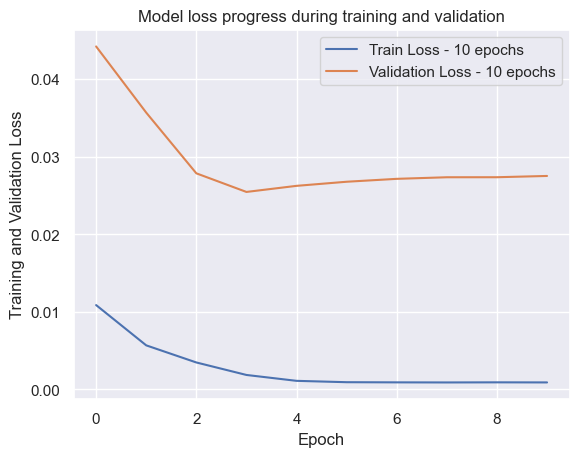

7/7 [==============================] - 0s 1ms/step
Train Score: 24.09 RMSE for 10 epochs
Test Score: 135.20 RMSE for 10 epochs
Training for 30 epochs...
Epoch 1/30
454/454 - 2s - loss: 0.0188 - val_loss: 0.0668 - 2s/epoch - 5ms/step
Epoch 2/30
454/454 - 1s - loss: 0.0102 - val_loss: 0.0562 - 685ms/epoch - 2ms/step
Epoch 3/30
454/454 - 1s - loss: 0.0078 - val_loss: 0.0415 - 681ms/epoch - 1ms/step
Epoch 4/30
454/454 - 1s - loss: 0.0045 - val_loss: 0.0296 - 682ms/epoch - 2ms/step
Epoch 5/30
454/454 - 1s - loss: 0.0016 - val_loss: 0.0270 - 695ms/epoch - 2ms/step
Epoch 6/30
454/454 - 1s - loss: 9.0861e-04 - val_loss: 0.0286 - 700ms/epoch - 2ms/step
Epoch 7/30
454/454 - 1s - loss: 8.8112e-04 - val_loss: 0.0292 - 703ms/epoch - 2ms/step
Epoch 8/30
454/454 - 1s - loss: 8.9937e-04 - val_loss: 0.0292 - 706ms/epoch - 2ms/step
Epoch 9/30
454/454 - 1s - loss: 8.9100e-04 - val_loss: 0.0296 - 783ms/epoch - 2ms/step
Epoch 10/30
454/454 - 1s - loss: 9.0915e-04 - val_loss: 0.0295 - 831ms/epoch - 2ms/step

Text(0.5, 1.0, 'Model loss progress during training and validation')

Text(0.5, 0, 'Epoch')

Text(0, 0.5, 'Training and Validation Loss')

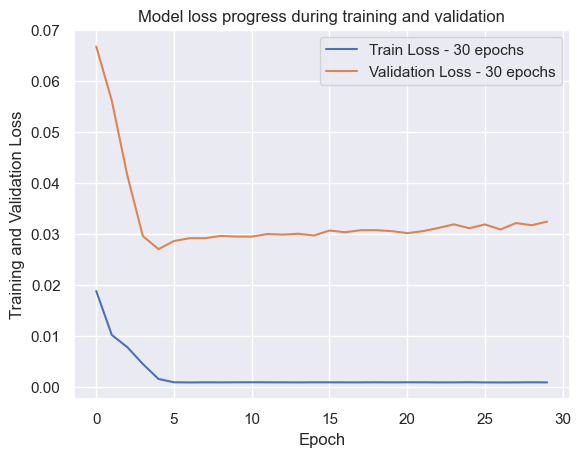

7/7 [==============================] - 0s 1ms/step
Train Score: 23.96 RMSE for 30 epochs
Test Score: 146.77 RMSE for 30 epochs
Training for 50 epochs...
Epoch 1/50
454/454 - 3s - loss: 0.0199 - val_loss: 0.0682 - 3s/epoch - 6ms/step
Epoch 2/50
454/454 - 1s - loss: 0.0110 - val_loss: 0.0579 - 695ms/epoch - 2ms/step
Epoch 3/50
454/454 - 1s - loss: 0.0090 - val_loss: 0.0498 - 695ms/epoch - 2ms/step
Epoch 4/50
454/454 - 1s - loss: 0.0069 - val_loss: 0.0417 - 701ms/epoch - 2ms/step
Epoch 5/50
454/454 - 1s - loss: 0.0047 - val_loss: 0.0314 - 693ms/epoch - 2ms/step
Epoch 6/50
454/454 - 1s - loss: 0.0026 - val_loss: 0.0270 - 696ms/epoch - 2ms/step
Epoch 7/50
454/454 - 1s - loss: 0.0013 - val_loss: 0.0279 - 686ms/epoch - 2ms/step
Epoch 8/50
454/454 - 1s - loss: 9.4335e-04 - val_loss: 0.0296 - 691ms/epoch - 2ms/step
Epoch 9/50
454/454 - 1s - loss: 8.6120e-04 - val_loss: 0.0305 - 690ms/epoch - 2ms/step
Epoch 10/50
454/454 - 1s - loss: 8.8523e-04 - val_loss: 0.0307 - 692ms/epoch - 2ms/step
Epoch 1

Text(0.5, 1.0, 'Model loss progress during training and validation')

Text(0.5, 0, 'Epoch')

Text(0, 0.5, 'Training and Validation Loss')

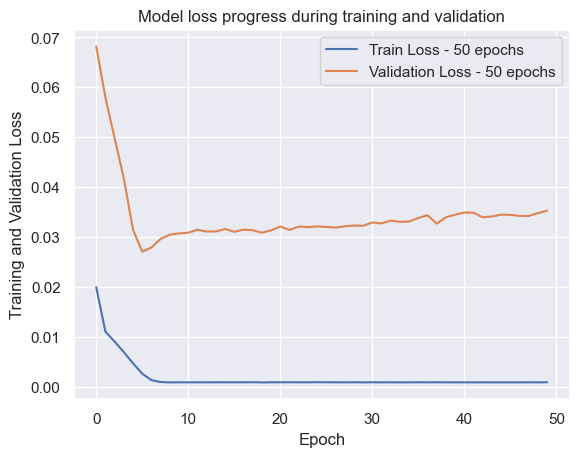

7/7 [==============================] - 0s 1ms/step
Train Score: 24.35 RMSE for 50 epochs
Test Score: 153.05 RMSE for 50 epochs
Training for 100 epochs...
Epoch 1/100
454/454 - 2s - loss: 0.0073 - val_loss: 0.0341 - 2s/epoch - 5ms/step
Epoch 2/100
454/454 - 1s - loss: 0.0034 - val_loss: 0.0280 - 696ms/epoch - 2ms/step
Epoch 3/100
454/454 - 1s - loss: 0.0018 - val_loss: 0.0260 - 700ms/epoch - 2ms/step
Epoch 4/100
454/454 - 1s - loss: 0.0011 - val_loss: 0.0270 - 712ms/epoch - 2ms/step
Epoch 5/100
454/454 - 1s - loss: 9.0982e-04 - val_loss: 0.0281 - 701ms/epoch - 2ms/step
Epoch 6/100
454/454 - 1s - loss: 8.9534e-04 - val_loss: 0.0285 - 701ms/epoch - 2ms/step
Epoch 7/100
454/454 - 1s - loss: 8.8566e-04 - val_loss: 0.0288 - 691ms/epoch - 2ms/step
Epoch 8/100
454/454 - 1s - loss: 9.0518e-04 - val_loss: 0.0283 - 701ms/epoch - 2ms/step
Epoch 9/100
454/454 - 1s - loss: 9.0453e-04 - val_loss: 0.0284 - 693ms/epoch - 2ms/step
Epoch 10/100
454/454 - 1s - loss: 9.1100e-04 - val_loss: 0.0289 - 706ms/e

Text(0.5, 1.0, 'Model loss progress during training and validation')

Text(0.5, 0, 'Epoch')

Text(0, 0.5, 'Training and Validation Loss')

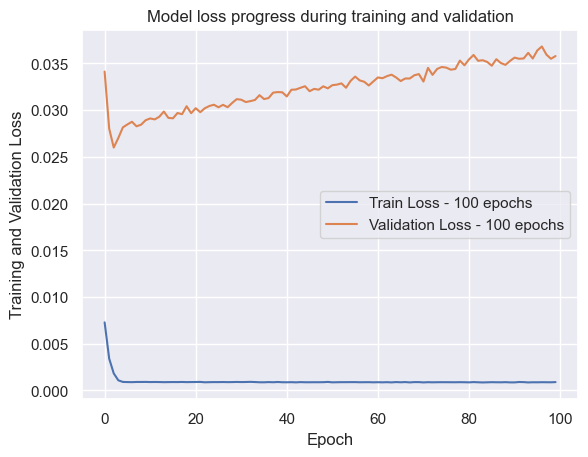

7/7 [==============================] - 0s 2ms/step
Train Score: 24.20 RMSE for 100 epochs
Test Score: 154.18 RMSE for 100 epochs
     Train RMSE   Test RMSE
10    24.087357  135.197660
30    23.957311  146.770535
50    24.349461  153.047214
100   24.200368  154.179231


In [19]:
# Normalize dataset for LSTM
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler(feature_range=(0, 1))
dataset = scaler.fit_transform(df_lstm1['Rate'].values.reshape(-1,1))

# Split into train and test sets
train_size = int(len(dataset) * 0.7)
test_size = len(dataset) - train_size
train, test = dataset[0:train_size,:], dataset[train_size:len(dataset),:]

# Reshape into X=t and Y=t+1, timestep  look_back
look_back = 1
trainX, trainY = create_dataset(train, look_back)
testX, testY = create_dataset(test, look_back)

# Reshape input to be [samples, time steps, features]
trainX = np.reshape(trainX, (trainX.shape[0], 1, trainX.shape[1]))
testX = np.reshape(testX, (testX.shape[0], 1, testX.shape[1]))

epochs_list = [10, 30, 50, 100]

rmse_results = {}

for epochs in epochs_list:
    print(f'Training for {epochs} epochs...')
    model, history = create_LSTM_model(trainX, trainY, testX, testY, epochs)
    
    # Add the loss for this model to the plot
    plt.plot(history.history['loss'], label=f'Train Loss - {epochs} epochs')
    plt.plot(history.history['val_loss'], label=f'Validation Loss - {epochs} epochs')

    # Configure and show the plot
    plt.title('Model loss progress during training and validation')
    plt.xlabel('Epoch')
    plt.ylabel('Training and Validation Loss')
    plt.legend()
    plt.show();

    # Evalute LSTM Model
    trainPredict = model.predict(trainX)
    testPredict = model.predict(testX)

    # Invert predictions back to prescaled values
    trainPredict = scaler.inverse_transform(trainPredict)
    trainY_orig = scaler.inverse_transform([trainY])
    testPredict = scaler.inverse_transform(testPredict)
    testY_orig = scaler.inverse_transform([testY])

    # Calculate mean squared error
    trainScore = calculate_RMSE(trainY_orig[0], trainPredict[:,0])
    print(f'Train Score: {trainScore:.2f} RMSE for {epochs} epochs')
    testScore = calculate_RMSE(testY_orig[0], testPredict[:,0])
    print(f'Test Score: {testScore:.2f} RMSE for {epochs} epochs')

    rmse_results[epochs] = {'Train RMSE': trainScore, 'Test RMSE': testScore}

# Convert the dictionary to a DataFrame for easy display
rmse_df = pd.DataFrame(rmse_results).T
print(rmse_df)

# # View how LSTM model fitting to the actual data
# plot_predictions_v1(dataset, trainPredict, testPredict, look_back)


<h4>Testing LSTM Regression model with external features</h4>

In [23]:
def create_dataset_v2(dataset, look_back=1):
    dataX, dataY = [], []
    for i in range(len(dataset) - look_back):
        a = dataset[i:(i+look_back)]
        dataX.append(a)
        dataY.append(dataset[i + look_back])
    return np.array(dataX), np.array(dataY)

,YearMonthWeek,Rate,Covid
0,2005-09-27,390.0,0
1,2005-10-04,390.0,0
2,2005-10-18,390.0,0
3,2005-10-25,390.0,0
4,2005-11-01,390.0,0


,YearMonthWeek,Rate,Covid
647,2023-04-04,280.0,0
648,2023-04-11,260.0,0
649,2023-04-18,300.0,0
650,2023-04-25,260.0,0
651,2023-05-02,300.0,0


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 652 entries, 0 to 651
Data columns (total 3 columns):
 #   Column         Non-Null Count  Dtype         
---  ------         --------------  -----         
 0   YearMonthWeek  652 non-null    datetime64[ns]
 1   Rate           652 non-null    float64       
 2   Covid          652 non-null    int64         
dtypes: datetime64[ns](1), float64(1), int64(1)
memory usage: 15.4 KB
Training for 10 epochs...
Epoch 1/10
455/455 - 2s - loss: 0.0114 - val_loss: 0.0481 - 2s/epoch - 5ms/step
Epoch 2/10
455/455 - 1s - loss: 0.0054 - val_loss: 0.0407 - 687ms/epoch - 2ms/step
Epoch 3/10
455/455 - 1s - loss: 0.0033 - val_loss: 0.0316 - 708ms/epoch - 2ms/step
Epoch 4/10
455/455 - 1s - loss: 0.0018 - val_loss: 0.0272 - 692ms/epoch - 2ms/step
Epoch 5/10
455/455 - 1s - loss: 0.0011 - val_loss: 0.0269 - 696ms/epoch - 2ms/step
Epoch 6/10
455/455 - 1s - loss: 9.1166e-04 - val_loss: 0.0271 - 680ms/epoch - 1ms/step
Epoch 7/10
455/455 - 1s - loss: 8.9409e-04 - v

Text(0.5, 1.0, 'Model loss progress during training and validation')

Text(0.5, 0, 'Epoch')

Text(0, 0.5, 'Training and Validation Loss')

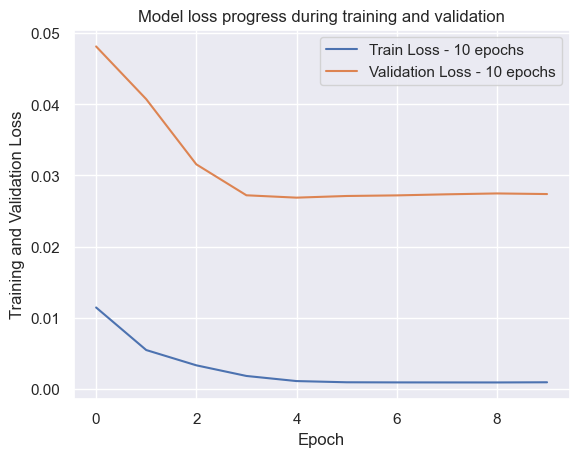

7/7 [==============================] - 0s 1ms/step
Train Score: 24.07 RMSE for 10 epochs
Test Score: 134.86 RMSE for 10 epochs
Training for 30 epochs...
Epoch 1/30
455/455 - 2s - loss: 0.0199 - val_loss: 0.0582 - 2s/epoch - 5ms/step
Epoch 2/30
455/455 - 1s - loss: 0.0107 - val_loss: 0.0524 - 770ms/epoch - 2ms/step
Epoch 3/30
455/455 - 1s - loss: 0.0084 - val_loss: 0.0449 - 723ms/epoch - 2ms/step
Epoch 4/30
455/455 - 1s - loss: 0.0061 - val_loss: 0.0385 - 756ms/epoch - 2ms/step
Epoch 5/30
455/455 - 1s - loss: 0.0038 - val_loss: 0.0320 - 726ms/epoch - 2ms/step
Epoch 6/30
455/455 - 1s - loss: 0.0021 - val_loss: 0.0289 - 776ms/epoch - 2ms/step
Epoch 7/30
455/455 - 1s - loss: 0.0012 - val_loss: 0.0276 - 710ms/epoch - 2ms/step
Epoch 8/30
455/455 - 1s - loss: 9.3335e-04 - val_loss: 0.0276 - 851ms/epoch - 2ms/step
Epoch 9/30
455/455 - 1s - loss: 8.8422e-04 - val_loss: 0.0274 - 795ms/epoch - 2ms/step
Epoch 10/30
455/455 - 1s - loss: 8.8628e-04 - val_loss: 0.0276 - 821ms/epoch - 2ms/step
Epoch 1

Text(0.5, 1.0, 'Model loss progress during training and validation')

Text(0.5, 0, 'Epoch')

Text(0, 0.5, 'Training and Validation Loss')

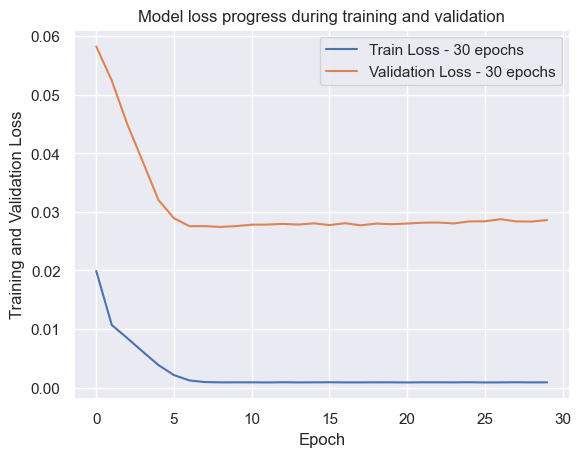

7/7 [==============================] - 0s 1ms/step
Train Score: 24.35 RMSE for 30 epochs
Test Score: 137.82 RMSE for 30 epochs
Training for 50 epochs...
Epoch 1/50
455/455 - 3s - loss: 0.0075 - val_loss: 0.0626 - 3s/epoch - 5ms/step
Epoch 2/50
455/455 - 1s - loss: 0.0035 - val_loss: 0.0543 - 888ms/epoch - 2ms/step
Epoch 3/50
455/455 - 1s - loss: 0.0019 - val_loss: 0.0540 - 825ms/epoch - 2ms/step
Epoch 4/50
455/455 - 1s - loss: 0.0011 - val_loss: 0.0565 - 792ms/epoch - 2ms/step
Epoch 5/50
455/455 - 1s - loss: 9.1363e-04 - val_loss: 0.0615 - 825ms/epoch - 2ms/step
Epoch 6/50
455/455 - 1s - loss: 9.0506e-04 - val_loss: 0.0592 - 791ms/epoch - 2ms/step
Epoch 7/50
455/455 - 1s - loss: 9.0558e-04 - val_loss: 0.0572 - 780ms/epoch - 2ms/step
Epoch 8/50
455/455 - 1s - loss: 9.0304e-04 - val_loss: 0.0593 - 796ms/epoch - 2ms/step
Epoch 9/50
455/455 - 1s - loss: 9.1735e-04 - val_loss: 0.0569 - 790ms/epoch - 2ms/step
Epoch 10/50
455/455 - 1s - loss: 9.1199e-04 - val_loss: 0.0561 - 812ms/epoch - 2ms/

Text(0.5, 1.0, 'Model loss progress during training and validation')

Text(0.5, 0, 'Epoch')

Text(0, 0.5, 'Training and Validation Loss')

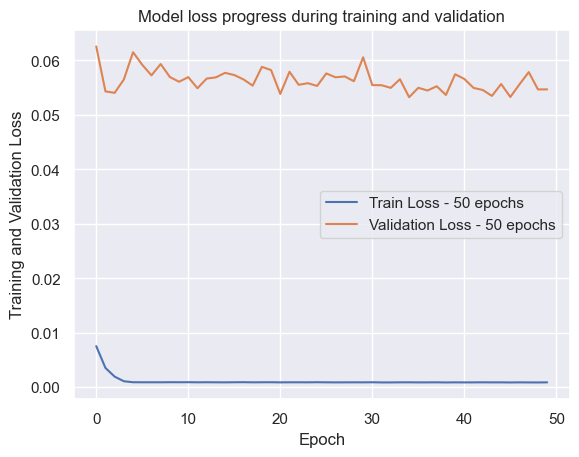

7/7 [==============================] - 0s 1ms/step
Train Score: 23.77 RMSE for 50 epochs
Test Score: 190.56 RMSE for 50 epochs
Training for 100 epochs...
Epoch 1/100
455/455 - 3s - loss: 0.0220 - val_loss: 0.0807 - 3s/epoch - 6ms/step
Epoch 2/100
455/455 - 1s - loss: 0.0111 - val_loss: 0.0685 - 837ms/epoch - 2ms/step
Epoch 3/100
455/455 - 1s - loss: 0.0090 - val_loss: 0.0574 - 802ms/epoch - 2ms/step
Epoch 4/100
455/455 - 1s - loss: 0.0068 - val_loss: 0.0459 - 798ms/epoch - 2ms/step
Epoch 5/100
455/455 - 1s - loss: 0.0044 - val_loss: 0.0406 - 809ms/epoch - 2ms/step
Epoch 6/100
455/455 - 1s - loss: 0.0025 - val_loss: 0.0352 - 798ms/epoch - 2ms/step
Epoch 7/100
455/455 - 1s - loss: 0.0014 - val_loss: 0.0355 - 800ms/epoch - 2ms/step
Epoch 8/100
455/455 - 1s - loss: 9.5661e-04 - val_loss: 0.0351 - 790ms/epoch - 2ms/step
Epoch 9/100
455/455 - 1s - loss: 8.8664e-04 - val_loss: 0.0368 - 808ms/epoch - 2ms/step
Epoch 10/100
455/455 - 1s - loss: 8.6495e-04 - val_loss: 0.0361 - 847ms/epoch - 2ms/s

Text(0.5, 1.0, 'Model loss progress during training and validation')

Text(0.5, 0, 'Epoch')

Text(0, 0.5, 'Training and Validation Loss')

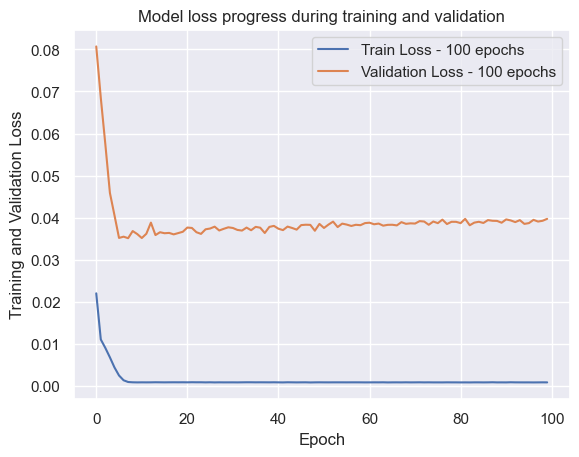

7/7 [==============================] - 0s 1ms/step
Train Score: 23.79 RMSE for 100 epochs
Test Score: 162.45 RMSE for 100 epochs
     Train RMSE   Test RMSE
10    24.072117  134.859754
30    24.354127  137.821110
50    23.770673  190.564097
100   23.790383  162.445663


In [24]:
# Dataframe for LSTM2
df_lstm2 = agg_df[['YearMonthWeek','Rate']].copy()

# Create a new column indicating whether each month is affected by COVID-19
df_lstm2['Covid'] = 0
df_lstm2.loc[(df_lstm2['YearMonthWeek'] >= '2020-01') & (df_lstm2['YearMonthWeek'] <= '2023-01'), 'Covid'] = 1

df_lstm2.head()
df_lstm2.tail()
df_lstm2.info()

# Fit a separate scaler for 'Rate'
scaler_rate = MinMaxScaler(feature_range=(0, 1))
df_lstm2['Rate'] = scaler_rate.fit_transform(df_lstm2['Rate'].values.reshape(-1,1))

# Split into train and test sets
train_size = int(len(df_lstm2) * 0.7)
test_size = len(df_lstm2) - train_size
train, test = df_lstm2.iloc[0:train_size,:], df_lstm2.iloc[train_size:len(df_lstm2),:]

# Prepare data for LSTM
look_back = 1
trainX, trainY = create_dataset_v2(train['Rate'].values, look_back)
testX, testY = create_dataset_v2(test['Rate'].values, look_back)

# Add Covid column to the features
trainX = np.hstack((trainX, train['Covid'][:-look_back].values.reshape(-1,1)))
testX = np.hstack((testX, test['Covid'][:-look_back].values.reshape(-1,1)))

# Reshape input to be [samples, time steps, features]
trainX = np.reshape(trainX, (trainX.shape[0], 1, trainX.shape[1]))
testX = np.reshape(testX, (testX.shape[0], 1, testX.shape[1]))

epochs_list = [10, 30, 50, 100]

rmse_results = {}

for epochs in epochs_list:
    print(f'Training for {epochs} epochs...')
    model, history = create_LSTM_model(trainX, trainY, testX, testY, epochs)
    
    # Add the loss for this model to the plot
    plt.plot(history.history['loss'], label=f'Train Loss - {epochs} epochs')
    plt.plot(history.history['val_loss'], label=f'Validation Loss - {epochs} epochs')

    # Configure and show the plot
    plt.title('Model loss progress during training and validation')
    plt.xlabel('Epoch')
    plt.ylabel('Training and Validation Loss')
    plt.legend()
    plt.show();

    # Evalute LSTM Model
    trainPredict = model.predict(trainX)
    testPredict = model.predict(testX)

    # Invert predictions back to prescaled values
    trainPredict = scaler.inverse_transform(trainPredict)
    trainY_orig = scaler.inverse_transform([trainY])
    testPredict = scaler.inverse_transform(testPredict)
    testY_orig = scaler.inverse_transform([testY])

    # Calculate mean squared error
    trainScore = calculate_RMSE(trainY_orig[0], trainPredict[:,0])
    print(f'Train Score: {trainScore:.2f} RMSE for {epochs} epochs')
    testScore = calculate_RMSE(testY_orig[0], testPredict[:,0])
    print(f'Test Score: {testScore:.2f} RMSE for {epochs} epochs')

    rmse_results[epochs] = {'Train RMSE': trainScore, 'Test RMSE': testScore}

# Convert the dictionary to a DataFrame for easy display
rmse_df2 = pd.DataFrame(rmse_results).T
print(rmse_df2)

# # Plot predictions
# plot_predictions_v2(df_lstm2, trainPredict, testPredict, look_back)


In [30]:
print("Without Additional Covid Features for LSTM(Data = Weeks)")
print(rmse_df)
print("\n")

print("With Additional Covid Features for LSTM(Data = Weeks)")
print(rmse_df2)

Without Additional Covid Features for LSTM(Data = Weeks)
     Train RMSE   Test RMSE
10    24.087357  135.197660
30    23.957311  146.770535
50    24.349461  153.047214
100   24.200368  154.179231


With Additional Covid Features for LSTM(Data = Weeks)
     Train RMSE   Test RMSE
10    24.072117  134.859754
30    24.354127  137.821110
50    23.770673  190.564097
100   23.790383  162.445663


<h4>Modeling For ARIMA<h4>

In [31]:
# Dataframe for ARIMA For Log Transform
df_arima1 = agg_df[['YearMonthWeek','Rate']].copy()
df_arima1.set_index('YearMonthWeek', inplace=True)
df_arima1.head()
df_arima1.info()

# Dataframe for ARIMA 
df_arima2 = agg_df[['YearMonthWeek','Rate']].copy()
df_arima2.set_index('YearMonthWeek', inplace=True)
df_arima2.head()
df_arima2.info()

,Rate
YearMonthWeek,
2005-09-27,390.0
2005-10-04,390.0
2005-10-18,390.0
2005-10-25,390.0
2005-11-01,390.0


<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 652 entries, 2005-09-27 to 2023-05-02
Data columns (total 1 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   Rate    652 non-null    float64
dtypes: float64(1)
memory usage: 10.2 KB


,Rate
YearMonthWeek,
2005-09-27,390.0
2005-10-04,390.0
2005-10-18,390.0
2005-10-25,390.0
2005-11-01,390.0


<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 652 entries, 2005-09-27 to 2023-05-02
Data columns (total 1 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   Rate    652 non-null    float64
dtypes: float64(1)
memory usage: 10.2 KB


In [32]:
import numpy as np
import matplotlib.pyplot as plt
import pmdarima as pm
from sklearn.metrics import mean_squared_error

# Apply logarithm transformation to 'Rate' column
df_arima1['Rate'] = np.log(df_arima1['Rate'])

# Fit an auto_arima model
arima_model1 = pm.auto_arima(df_arima1['Rate'], start_p=1, start_q=1, 
                            max_p=3, max_q=3, m=12,
                            start_P=0, seasonal=False, 
                            d=1, D=1, trace=True,
                            error_action='ignore',  # don't want to know if an order does not work
                            suppress_warnings=True,  # don't want convergence warnings
                            stepwise=True)  # set to stepwise

# Print the summary of the model
print(arima_model1.summary())

# Split the data into training and test data
train_size1 = int(len(df_arima1) * 0.7)
train1, test1 = df_arima1[0:train_size1], df_arima1[train_size1:]

# Train the model on the training data
arima_model1.fit(train['Rate'])

# Forecast
train_forecast1, conf_int_train1 = arima_model1.predict(n_periods=len(train1), return_conf_int=True)
test_forecast1, conf_int_test1 = arima_model1.predict(n_periods=len(test1), return_conf_int=True)

# Reverse the logarithm transformation
train1['Rate'] = np.exp(train1['Rate'])
test1['Rate'] = np.exp(test1['Rate'])
train_forecast1 = np.exp(train_forecast1)
test_forecast1 = np.exp(test_forecast1)
conf_int_train1 = np.exp(conf_int_train1)
conf_int_test1 = np.exp(conf_int_test1)

# Calculate the RMSE
RMSE_ARIMA_train1 = np.sqrt(mean_squared_error(train1['Rate'], train_forecast1))
print("Train RMSE: %.3f" % RMSE_ARIMA_train1)
RMSE_ARIMA_test1 = np.sqrt(mean_squared_error(test1['Rate'], test_forecast1))
print("Test RMSE: %.3f" % RMSE_ARIMA_test1)


c:\Users\Aloysius Wong\Documents\GitHub\Cost-Rate-Analysis\env\lib\site-packages\pmdarima\arima\_validation.py:62: UserWarning: m (12) set for non-seasonal fit. Setting to 0
  warnings.warn("m (%i) set for non-seasonal fit. Setting to 0" % m)


Performing stepwise search to minimize aic
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=183.179, Time=0.14 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=330.203, Time=0.05 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=203.016, Time=0.07 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=181.490, Time=0.13 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=328.204, Time=0.04 sec
 ARIMA(0,1,2)(0,0,0)[0] intercept   : AIC=183.242, Time=0.14 sec
 ARIMA(1,1,2)(0,0,0)[0] intercept   : AIC=184.133, Time=0.26 sec
 ARIMA(0,1,1)(0,0,0)[0]             : AIC=179.498, Time=0.04 sec
 ARIMA(1,1,1)(0,0,0)[0]             : AIC=181.186, Time=0.09 sec
 ARIMA(0,1,2)(0,0,0)[0]             : AIC=181.250, Time=0.07 sec
 ARIMA(1,1,0)(0,0,0)[0]             : AIC=201.019, Time=0.04 sec
 ARIMA(1,1,2)(0,0,0)[0]             : AIC=182.140, Time=0.15 sec

Best model:  ARIMA(0,1,1)(0,0,0)[0]          
Total fit time: 1.224 seconds
                               SARIMAX Results                                
Dep. Variable:       

ARIMA(order=(0, 1, 1), scoring_args={}, suppress_warnings=True,
      with_intercept=False)

Train RMSE: 192.781
Test RMSE: 308.211


C:\Users\Aloysius Wong\AppData\Local\Temp\ipykernel_2760\3072854943.py:33: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train1['Rate'] = np.exp(train1['Rate'])
C:\Users\Aloysius Wong\AppData\Local\Temp\ipykernel_2760\3072854943.py:34: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test1['Rate'] = np.exp(test1['Rate'])


In [33]:
import pmdarima as pm
from sklearn.metrics import mean_squared_error

# Split the data into training and test data
train_size2 = int(len(df_arima2) * 0.7)
train2, test2 = df_arima2[0:train_size2], df_arima2[train_size2:]

# Fit an auto_arima model
arima_model2 = pm.auto_arima(train2['Rate'], start_p=1, start_q=1, 
                            max_p=12, max_q=12, m=12,
                            start_P=0, seasonal=False, 
                            d=0, D=0, trace=True,
                            error_action='ignore', 
                            suppress_warnings=True, 
                            stepwise=True)  # set to stepwise

# Print the summary of the model
print(arima_model2.summary())

# Forecast
train_forecast2 = arima_model2.predict_in_sample()
test_forecast2 = arima_model2.predict(n_periods=len(test2))

# Calculate the RMSE
RMSE_ARIMA_train2 = np.sqrt(mean_squared_error(train2['Rate'], train_forecast2))
print("Train RMSE: %.3f" % RMSE_ARIMA_train2)
RMSE_ARIMA_test2 = np.sqrt(mean_squared_error(test2['Rate'], test_forecast2))
print("Test RMSE: %.3f" % RMSE_ARIMA_test2)


c:\Users\Aloysius Wong\Documents\GitHub\Cost-Rate-Analysis\env\lib\site-packages\pmdarima\arima\_validation.py:62: UserWarning: m (12) set for non-seasonal fit. Setting to 0
  warnings.warn("m (%i) set for non-seasonal fit. Setting to 0" % m)


Performing stepwise search to minimize aic
 ARIMA(1,0,1)(0,0,0)[0]             : AIC=4173.387, Time=0.08 sec
 ARIMA(0,0,0)(0,0,0)[0]             : AIC=6099.401, Time=0.01 sec
 ARIMA(1,0,0)(0,0,0)[0]             : AIC=inf, Time=0.02 sec
 ARIMA(0,0,1)(0,0,0)[0]             : AIC=5560.796, Time=0.08 sec
 ARIMA(2,0,1)(0,0,0)[0]             : AIC=4175.343, Time=0.12 sec
 ARIMA(1,0,2)(0,0,0)[0]             : AIC=4175.320, Time=0.11 sec
 ARIMA(0,0,2)(0,0,0)[0]             : AIC=5193.086, Time=0.25 sec
 ARIMA(2,0,0)(0,0,0)[0]             : AIC=inf, Time=0.06 sec
 ARIMA(2,0,2)(0,0,0)[0]             : AIC=inf, Time=0.34 sec
 ARIMA(1,0,1)(0,0,0)[0] intercept   : AIC=4171.898, Time=0.12 sec
 ARIMA(0,0,1)(0,0,0)[0] intercept   : AIC=4954.676, Time=0.12 sec
 ARIMA(1,0,0)(0,0,0)[0] intercept   : AIC=4216.421, Time=0.06 sec
 ARIMA(2,0,1)(0,0,0)[0] intercept   : AIC=4173.882, Time=0.18 sec
 ARIMA(1,0,2)(0,0,0)[0] intercept   : AIC=4173.873, Time=0.23 sec
 ARIMA(0,0,0)(0,0,0)[0] intercept   : AIC=5394.2

c:\Users\Aloysius Wong\Documents\GitHub\Cost-Rate-Analysis\env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:834: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
